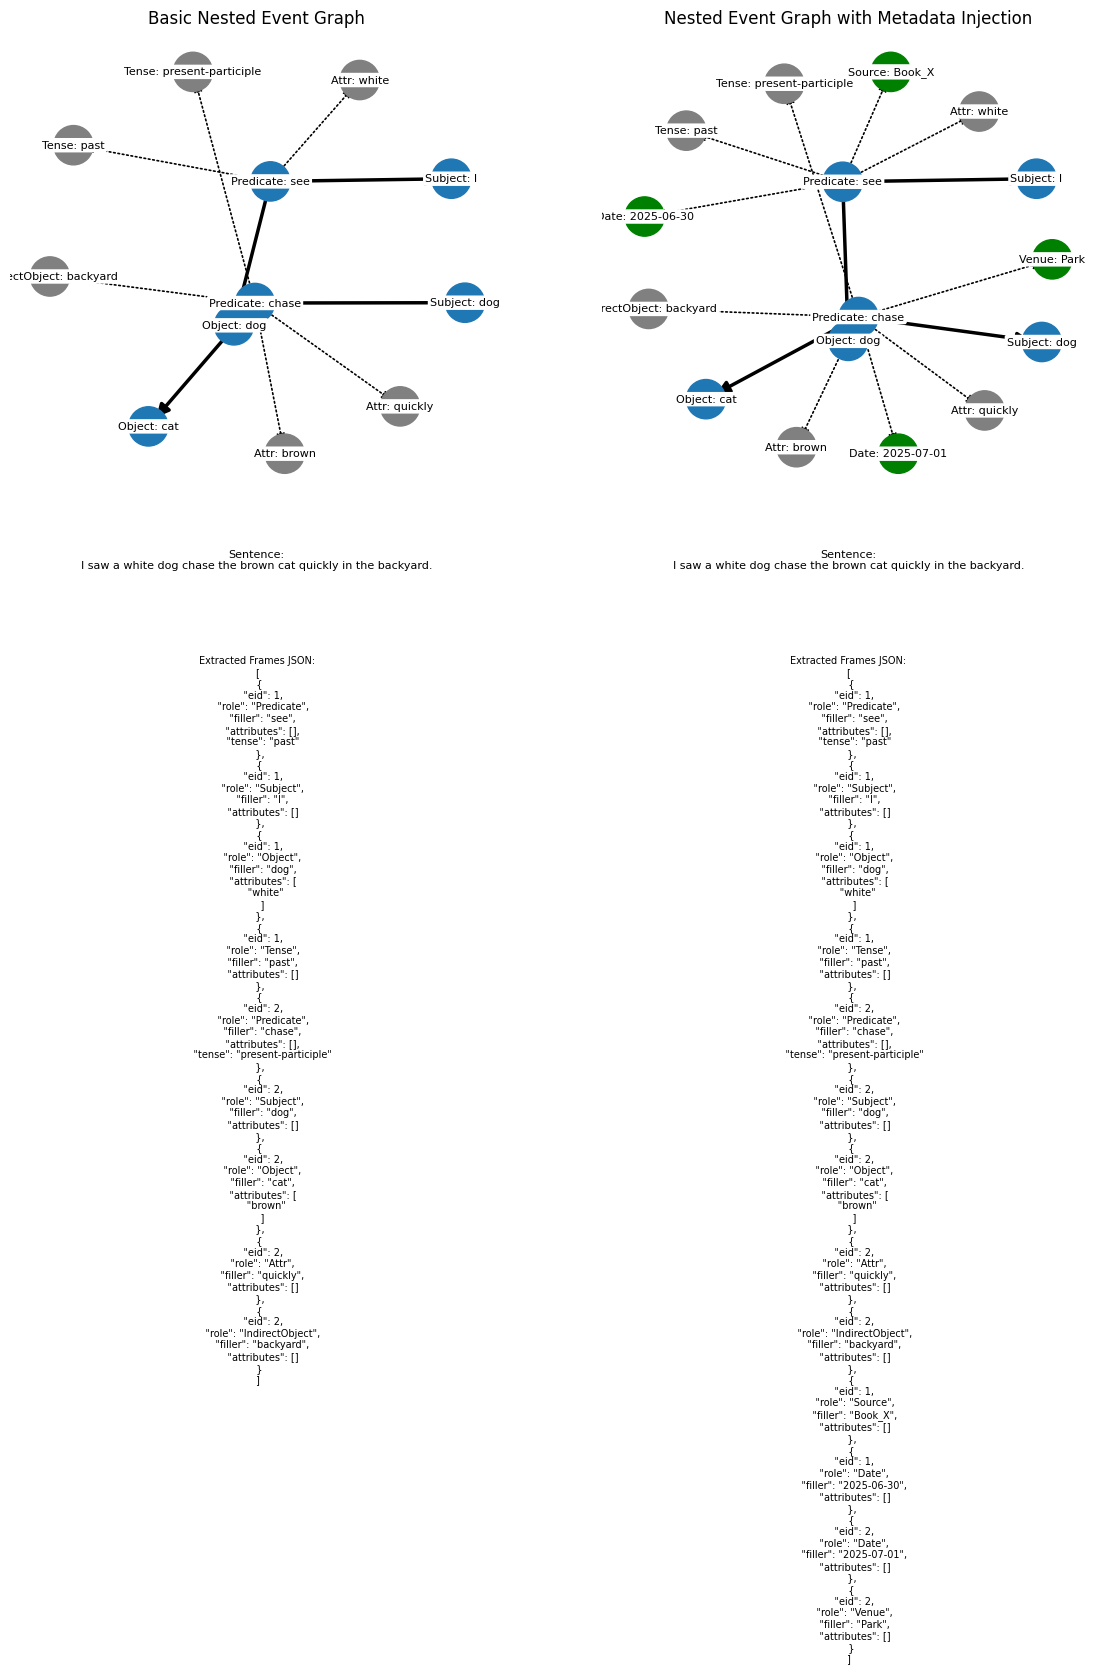

In [15]:
#!/usr/bin/env python3
import networkx as nx
import matplotlib.pyplot as plt
import json

def build_basic_graph():
    G = nx.DiGraph()
    # Event 1
    G.add_node(('e1','Predicate','see'), role='Predicate', filler='see', ntype='spo')
    G.add_node(('e1','Subject','I'),      role='Subject',   filler='I',   ntype='spo')
    G.add_node(('e1','Object','dog'),     role='Object',    filler='dog', ntype='spo')
    G.add_node(('e1','Tense','past'),     role='Tense',     filler='past',ntype='attr')
    G.add_node(('e1','Attr','white'),     role='Attr',      filler='white',ntype='attr')
    # Event 2 (nested under dog)
    G.add_node(('e2','Predicate','chase'),           role='Predicate',   filler='chase', ntype='spo')
    G.add_node(('e2','Subject','dog'),               role='Subject',     filler='dog',    ntype='spo')
    G.add_node(('e2','Object','cat'),                role='Object',      filler='cat',    ntype='spo')
    G.add_node(('e2','Tense','present-participle'), role='Tense',       filler='present-participle',ntype='attr')
    G.add_node(('e2','Attr','brown'),                role='Attr',        filler='brown', ntype='attr')
    G.add_node(('e2','Attr','quickly'),              role='Attr',        filler='quickly',ntype='attr')
    G.add_node(('e2','IndirectObject','backyard'),   role='IndirectObject',filler='backyard',ntype='attr')

    # Edges for event1 (solid)
    G.add_edges_from([
        (('e1','Predicate','see'), ('e1','Subject','I')),
        (('e1','Predicate','see'), ('e1','Object','dog')),
    ])
    # attribute edges for event1
    G.add_edges_from([
        (('e1','Predicate','see'), ('e1','Tense','past')),
        (('e1','Predicate','see'), ('e1','Attr','white')),
    ])

    # Edges for event2
    G.add_edges_from([
        (('e2','Predicate','chase'), ('e2','Subject','dog')),
        (('e2','Predicate','chase'), ('e2','Object','cat')),
    ])
    # attribute edges for event2
    G.add_edges_from([
        (('e2','Predicate','chase'), ('e2','Tense','present-participle')),
        (('e2','Predicate','chase'), ('e2','Attr','brown')),
        (('e2','Predicate','chase'), ('e2','Attr','quickly')),
        (('e2','Predicate','chase'), ('e2','IndirectObject','backyard')),
    ])

    # Nested SPO link: object of e1 → predicate of e2
    G.add_edge(('e1','Object','dog'), ('e2','Predicate','chase'))
    return G

def build_extended_graph():
    G = build_basic_graph()
    # Out‐of‐sentence metadata (green)
    G.add_node(('e1','Source','Book_X'), role='Source', filler='Book_X', ntype='meta_out')
    G.add_node(('e1','Date','2025-06-30'),role='Date',   filler='2025-06-30', ntype='meta_out')
    G.add_edges_from([
        (('e1','Predicate','see'), ('e1','Source','Book_X')),
        (('e1','Predicate','see'), ('e1','Date','2025-06-30')),
    ])
    G.add_node(('e2','Date','2025-07-01'), role='Date',  filler='2025-07-01', ntype='meta_out')
    G.add_node(('e2','Venue','Park'),      role='Venue', filler='Park',       ntype='meta_out')
    G.add_edges_from([
        (('e2','Predicate','chase'), ('e2','Date','2025-07-01')),
        (('e2','Predicate','chase'), ('e2','Venue','Park')),
    ])
    return G

def draw_graph(ax, G, title, sentence, frames):
    # use a looser spring layout to push nodes apart
    pos = nx.spring_layout(G, seed=42, k=1.2, iterations=200, scale=2.0)

    # node colors by type
    color_map = {'spo':'#1f77b4', 'attr':'grey', 'meta_out':'green'}
    node_colors = [ color_map[G.nodes[n]['ntype']] for n in G.nodes ]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, ax=ax)

    # labels
    labels = { n: f"{G.nodes[n]['role']}: {G.nodes[n]['filler']}" for n in G.nodes }
    nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax,
                            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none"))

    # split edges
    main_edges, attr_edges = [], []
    for u,v in G.edges():
        if G.nodes[v]['ntype']=='spo':
            main_edges.append((u,v))
        else:
            attr_edges.append((u,v))

    # solid thick for SPO links
    nx.draw_networkx_edges(
        G, pos, edgelist=main_edges, ax=ax,
        width=2.5, arrowstyle='-|>', arrowsize=18,
        edge_color='k'
    )
    # dotted thin for attributes & metadata
    nx.draw_networkx_edges(
        G, pos, edgelist=attr_edges, ax=ax,
        width=1.2, style='dotted', arrowstyle='-|>', arrowsize=12,
        edge_color='k'
    )

    ax.set_title(title)
    ax.axis('off')

    # add sentence & JSON below
    ax.text(0.5, -0.12, f"Sentence:\n{sentence}",
            transform=ax.transAxes, ha='center', va='top', fontsize=8)
    ax.text(0.5, -0.35,
            "Extracted Frames JSON:\n" + json.dumps(frames, indent=2),
            transform=ax.transAxes, ha='center', va='top', fontsize=7)

def main():
    sentence = "I saw a white dog chase the brown cat quickly in the backyard."
    basic_frames = [
      {"eid":1,"role":"Predicate","filler":"see","attributes":[],"tense":"past"},
      {"eid":1,"role":"Subject","filler":"I","attributes":[]},
      {"eid":1,"role":"Object","filler":"dog","attributes":["white"]},
      {"eid":1,"role":"Tense","filler":"past","attributes":[]},
      {"eid":2,"role":"Predicate","filler":"chase","attributes":[],"tense":"present-participle"},
      {"eid":2,"role":"Subject","filler":"dog","attributes":[]},
      {"eid":2,"role":"Object","filler":"cat","attributes":["brown"]},
      {"eid":2,"role":"Attr","filler":"quickly","attributes":[]},
      {"eid":2,"role":"IndirectObject","filler":"backyard","attributes":[]},
    ]
    extended_frames = basic_frames + [
      {"eid":1,"role":"Source","filler":"Book_X","attributes":[]},
      {"eid":1,"role":"Date","filler":"2025-06-30","attributes":[]},
      {"eid":2,"role":"Date","filler":"2025-07-01","attributes":[]},
      {"eid":2,"role":"Venue","filler":"Park","attributes":[]},
    ]

    G1 = build_basic_graph()
    G2 = build_extended_graph()

    fig, axes = plt.subplots(1,2,figsize=(14,6))
    draw_graph(axes[0], G1, "Basic Nested Event Graph", sentence, basic_frames)
    draw_graph(axes[1], G2, "Nested Event Graph with Metadata Injection",
               sentence, extended_frames)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
